# Introduction

Taxonomies are structured knowledge-bases representing the underlying concepts and principles often employed in classification [ref]. Specifically, a taxonomy refers to a *formal* schema incorporating an explicit specification of abstract concepts and their relationships [ref]. While most taxonomies depict hierarchical parent-child relationships such as hypernyms/hyponyms, however the broader principles generally apply to the realms of network structures [ref]. Mathematically, a hierarchical taxonomy is a tree structure of classifications for a given set of objects [ref].

Taxonomy learning deals with the automated extraction of knowledge as formal concepts and relationships from data in a semi/un-supervised manner. The obvious limitations on manual expertise combined with the enormous scale and complexity of data and computation motivate the need to learn representations and extract labeled, predictable groups amenable for (multi) classification.

In this study, we work towards the automated construction of a hierarchical taxonomy and evaluate its performance on customer-care problem/resolution ticket categories from a US based tier 1 cable network. The data is comprised of customer care tickets for a period of 21 days (Jan-Feb, 2017). Each subscriber has association with multiple tickets with each ticket containing information about:
* Line-Of-Business (LOB), ticket cause and resolution category hierarchies (**category->sub-category->description**)
* Contextual/Demographic attributes such as subscriber-type, device-type (**make, model**) and network topology hierarchy: (**network_level_xxx, make, model**)

## Problem Statement

Assuming that subscriber behaviour is captured through the various tickets issued, the similarity between behaviours may be determined from the overlap in their respective categories. Consequently, similar categories may also be determined from the overlap in subscriber behaviours. We seek to find low-dimensional representations of behaviours and subsequently obtain well-defined labeled classes and their relationships. Hierarchical representations have the advantage that they can be pruned to arbitrary resolutions under conditionally independent parent-child relationships.

Formally, define a bipartite graph $G(S,L,T)$ with S being the set of subscribers (entities) with tickets T (behaviours) composed of labels L; The weight between an entity, $E_{i}$ and label, $L_{j}$ is represented by a function, $F$ of a set of tickets, such as frequency or conditional probability.

$$T_{i,j} = \{t: t \in S_{i} \land L_{j} \in t\}; F: T_{i,j}-> R $$

Our goal is to find a collection of behaviors represented as a hierarchy with labeled relationships. This amounts to carrying out two major tasks recursively following a divide and conquer strategy:

    1. Finding clusters/children for a set of tickets
    2. Labeling the clusters to identify parent -> child relationships

In [1]:
import pandas as pd
import seaborn as sns
sns.set_palette("hls",n_colors=6)
%pylab inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.utils.arpack import eigsh
from scipy.sparse.linalg import svds
from sklearn.utils import check_random_state
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.validation import assert_all_finite
from scipy.sparse import dia_matrix, issparse

def scale_normalize(X):
    row_diag = np.asarray(1.0 / np.sqrt(X.sum(axis=1))).squeeze()
    col_diag = np.asarray(1.0 / np.sqrt(X.sum(axis=0))).squeeze()
    row_diag = np.where(np.isnan(row_diag), 0, row_diag)
    col_diag = np.where(np.isnan(col_diag), 0, col_diag)
    if issparse(X):
        n_rows, n_cols = X.shape
        r = dia_matrix((row_diag, [0]), shape=(n_rows, n_rows))
        c = dia_matrix((col_diag, [0]), shape=(n_cols, n_cols))
        an = r * X * c
    else:
        an = row_diag[:, np.newaxis] * X * col_diag
    return an, row_diag, col_diag

def svd(array, n_components, n_svd_vecs=None, random_state=None):
    u, s, vt = svds(array, k=n_components, ncv=n_svd_vecs)
    if np.any(np.isnan(vt)):
        A = safe_sparse_dot(array.T, array)
        random_state = check_random_state(random_state)
        v0 = random_state.uniform(-1, 1, A.shape[0])
        _, v = eigsh(A, k=n_components, ncv=n_svd_vecs, v0=v0, maxiter=5000)
        vt = v.T
    if np.any(np.isnan(u)):
        A = safe_sparse_dot(array, array.T)
        random_state = check_random_state(random_state)
        v0 = random_state.uniform(-1, 1, A.shape[0])
        _, u = eigsh(A, k=n_components, ncv=n_svd_vecs, v0=v0, maxiter=5000)
    assert_all_finite(u)
    assert_all_finite(vt)
    u, s, vt = u[:, np.argsort(s)[::-1]], s[np.argsort(s)[::-1]], vt[np.argsort(s)[::-1]]
    return u, s, vt.T
    
def spectral_transform(X,n_components,n_svd_vecs=None,n_discard=0):
    normalized_data, row_diag, col_diag = scale_normalize(X)
    u, s, v = svd(normalized_data, n_components, n_svd_vecs=n_svd_vecs)
    u, s, v = u[:,n_discard:], s[n_discard:], v[:,n_discard:]
    z = np.vstack((row_diag[:, np.newaxis] * u, col_diag[:, np.newaxis] * v))
    return z, s

class NullLeafException(Exception):
    pass

from sklearn.cluster import KMeans
def partition_labels(adj_mat,k,thres=(1,1),n_discard=0):
    laplacian, sv = spectral_transform(adj_mat,k,n_discard=n_discard)
    km = KMeans(n_clusters=k).fit(laplacian)
    row_clus, col_clus = km.labels_[:adj_mat.shape[0]], km.labels_[adj_mat.shape[0]:]
    clusters = {}
    for clus_id in set(km.labels_):
        rows_, cols_ = np.ravel(row_clus==clus_id), np.ravel(col_clus==clus_id)
        if sum(rows_)<thres[0] or sum(cols_)<thres[1]:
            raise NullLeafException("Leaf criteria not met: try smaller K")
        clusters[clus_id] = {"rows":rows_,"cols":cols_}
    return clusters

** Spectral Clustering: ** techniques make use of the spectrum (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. The goal of spectral clustering is to cluster data that is connected but not necessarily compact or clustered within convex boundaries [ref]. The **Spectral co-clustering** algorithm finds biclusters, i.e. simultaneous clusters on rows and columns such that each row and column belongs to exactly one bicluster. The algorithm treats the input data matrix as a bipartite graph and approximates the normalized cut of this graph to find strongly connected subgraphs.

Here is a synthetic example with 4 balanced size overlapping classes comprised of ~40 features (**Figures 1-2**). The selection of "K" is based on the eigen/spectral-gap shown in **Figure-3** with x-axis denoting number of clusters and y-axis denoting the corresponding singluar values. This is followed by an application of the spectral co-clustering algorithm evaluated on the confusion matrix of the recovered clusters (X) against the actual classes (Y). This example shows how one can use spectral methods to recover the original classes almost completely.

Actual         0      1      2      3
Predicted                            
0.0          NaN    NaN    NaN  250.0
1.0          NaN    NaN  250.0    NaN
2.0        250.0    NaN    NaN    NaN
3.0          NaN  250.0    NaN    NaN


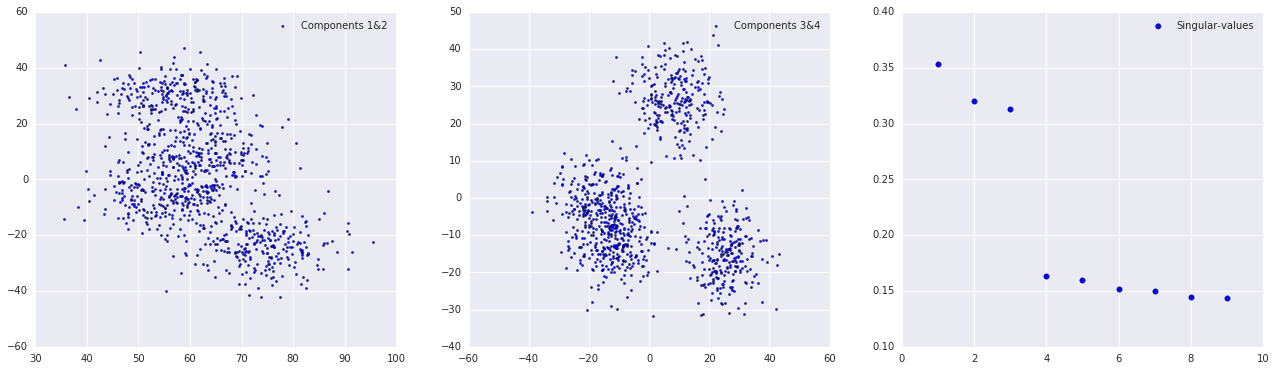

In [3]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn import decomposition
X, y = make_blobs(n_samples=1000, n_features=40, centers=4, cluster_std=7, center_box=(0,20))
X_pca = decomposition.TruncatedSVD(n_components=4).fit_transform(X)

fig,axes = plt.subplots(1,3,figsize=(22,6))
k=10
laplacian, sgvals = spectral_transform(X,k,n_discard=1)
axes[0].scatter(X_pca[:,0],X_pca[:,1],label="Components 1&2",s=5)
axes[0].legend()
axes[1].scatter(X_pca[:,2],X_pca[:,3],label="Components 3&4",s=5)
axes[1].legend()
axes[2].scatter(range(1,len(sgvals)+1),sgvals,s=30,label="Singular-values")
axes[2].legend()

n_clus = 4
clusters = partition_labels(X,k=n_clus)
y_pred = np.zeros(X.shape[0])
for clus_id,clus in clusters.items(): y_pred[clus['rows']] = clus_id
conf_mat = pd.DataFrame(zip(y_pred,y)).groupby(0)[1].value_counts().unstack()
conf_mat.index.name, conf_mat.columns.name="Predicted","Actual"
print conf_mat

## Methodology

We examine the following design as part of a general approach towards learning a taxonomic representation. The steps below illustrate the extraction, mapping, and labeling of clusters at a single-level in the taxonomy hierarchy. In order to arrive at the full hierarchical representation, these steps are executed in a recursive manner with appropriate termination conditions/heuristics based on statistical priors from the data.


### 1. Representation

For any given set of subscribers and tickets, the input is represented as a weighted bipartite graph mapping subscribers (entities) to their respective ticket-categories (behaviours). The co-occurrence frequencies/conditional probabilities may intuitively depict edge-weights and lend into simple interpretations. This graph is checked for connectivity and labeled.

### 2. Normalized Cut

Finding a globally optimal minimum cut vertex partitions to such a graph partitioning problem is NP-complete; An approximate solution to the optimal normalized cut may be found via the generalized eigenvalue decomposition of the Laplacian of the graph using the *Spectral co-clustering* algorithm [ref].

* Compute Normalized Laplacian, $Z=R^{-1/2}AC^{-1/2}$
* Search for "K" using Eigen-Gap heuristic
* Decompose $Z$'s top K components as truncated SVD: $[U,S,V]$
* Partition $X = [R^{-1/2}U,C^{-1/2}V]^{T}$ with K-Means

### 3. Label Assignment

The leaf partitions are identified using heuristics on the # samples and labeled as the category subset obtained from the normalized cut. Each ticket is assigned into a partition based on an "affinity" forumlated as the conditional probability of ticket category given subscriber.

In [4]:
categories = {"ticket_cause":['ticket_cause_category','ticket_cause_subcategory','ticket_cause_description'],\
              "ticket_resolution":['ticket_resolution_category','ticket_resolution_subcategory','ticket_resolution_description']}
ticket_features = list(np.ravel(categories.values()))
ids = ['account_id','ticket_id']

sub_tickets = pd.read_csv("data/tickets/tickets_clean",usecols=ids+ticket_features).fillna("MISSING")
sub_tickets['count'] = 1

cut = 5000
for feat in ticket_features:
    temp = sub_tickets[feat].value_counts()
    sub_tickets.loc[sub_tickets[feat].isin(temp[temp<cut].index),feat] = "OTHER"
    
ticket_tuples = sub_tickets.groupby(ticket_features)['count'].sum().sort_values(ascending=False).reset_index()[ticket_features].T.to_dict()
tick_inv_tuples = {tuple(v.values()):k for k,v in ticket_tuples.iteritems()}
sub_tickets['ticket_tuple'] = sub_tickets[ticket_tuples[0].keys()].apply(lambda x: tick_inv_tuples[tuple(x)],axis=1)
print "# ticket tuples: %s; \nticket tuple features: %s;"%(len(ticket_tuples.keys()),ticket_features)

# ticket tuples: 5804; 
ticket tuple features: ['ticket_cause_category', 'ticket_cause_subcategory', 'ticket_cause_description', 'ticket_resolution_category', 'ticket_resolution_subcategory', 'ticket_resolution_description'];


In [5]:
print "Fraction of ticket cause categories retained: %0.3f"%(sub_tickets['ticket_cause_category'].value_counts().iloc[1:].sum()/float(sub_tickets['ticket_cause_category'].value_counts().sum()))
print "Fraction of ticket resolution categories retained: %0.03f"%(sub_tickets['ticket_resolution_category'].value_counts().iloc[1:].sum()/float(sub_tickets['ticket_resolution_category'].value_counts().sum()))
print "Fraction of ticket cause subcategories retained: %0.3f"%(sub_tickets['ticket_cause_subcategory'].value_counts().iloc[1:].sum()/float(sub_tickets['ticket_cause_subcategory'].value_counts().sum()))
print "Fraction of ticket resolution subcategories retained: %0.03f"%(sub_tickets['ticket_resolution_subcategory'].value_counts().iloc[1:].sum()/float(sub_tickets['ticket_resolution_subcategory'].value_counts().sum()))
print "Fraction of ticket cause descriptions retained: %0.3f"%(sub_tickets['ticket_cause_description'].value_counts().iloc[1:].sum()/float(sub_tickets['ticket_cause_description'].value_counts().sum()))
print "Fraction of ticket resolution descriptions retained: %0.03f"%(sub_tickets['ticket_resolution_description'].value_counts().iloc[1:].sum()/float(sub_tickets['ticket_resolution_description'].value_counts().sum()))

Fraction of ticket cause categories retained: 0.631
Fraction of ticket resolution categories retained: 0.524
Fraction of ticket cause subcategories retained: 0.906
Fraction of ticket resolution subcategories retained: 0.826
Fraction of ticket cause descriptions retained: 0.798
Fraction of ticket resolution descriptions retained: 0.884


In [6]:
ticket_map = sub_tickets.groupby('ticket_id')['ticket_tuple'].max()
subs_tuple = sub_tickets.groupby('account_id')['ticket_tuple'].value_counts()
n_tickets = sub_tickets.groupby("account_id")['ticket_id'].nunique()

ticket_dummy = sub_tickets.copy()
for cat, cols in categories.items():
    for col in cols:
        ticket_dummy = pd.concat([ticket_dummy, \
                                  pd.get_dummies(ticket_dummy[col], prefix_sep=':', prefix=str(col), sparse=True)\
                                  .astype(np.int8)], axis=1).drop(col, axis=1)

In [7]:
dummy_cols = [i for i in ticket_dummy.columns for j in ticket_features if j in i]
freq_mat = ticket_dummy.groupby('account_id')[dummy_cols].sum()
freq_mat = freq_mat.loc[freq_mat.sum(axis=1)>0,freq_mat.sum(axis=0)>0]
subscribers = freq_mat.index
dummy_cols = freq_mat.columns

## HIERARCHICAL TAXONOMY

We define parameters for any given cluster to be labeled as leaf/non-leaf in the hierarchical partitioning algorithm. Non-leaf nodes are isolated and recursively split following the above steps until they are identified as leaf nodes per the following heuristics:

* *prune_thres* : The threshold for labels
* *max_depth* : The maximum depth of the tree
* *min_samples_split* : The minimum number of samples required to split an internal node
* *min_samples_leaf* : The minimum number of samples required to be at a leaf node
* *maxclus* : The maximum number of sub-clusters to search for at each split

### B. INTERNAL LABELS

The following methodology assumes that the internal tree nodes are assigned any labels thus restricting the taxonomy to include hierarchical relationships between the labels. Another assumption is that we consider pooled subscribers post partitioning while getting the subset of relationships between subscribers and tickets.

In [10]:
def assign_tuples(tuple_entity_mat,entity_clus_mat):
    tuple_clus_mat = np.dot(tuple_entity_mat,entity_clus_mat)
    return tuple_clus_mat

def P_F_C(X,weights,prob=True,thres=0):
    if prob:
        if issparse(X): return list(np.ravel(X.multiply(weights.values.reshape(-1,1)).sum(axis=0)/weights.sum()))
        else: return list(np.ravel(np.multiply(X,(weights.values.reshape(-1,1))).sum(axis=0)/weights.sum()))
    else:
        if issparse(X): return list(np.ravel((X > thres).multiply(weights.values.reshape(-1,1)).sum(axis=0)/weights.sum()))
        else: return list(np.ravel(np.multiply((X > thres),(weights.values.reshape(-1,1))).sum(axis=0)/weights.sum()))

def P_C_F(X,childinds,weights,prob=True,thres=0):
    if prob:
        if issparse(X): return [(X[childinds.values,i].multiply(weights[childinds.values].values.reshape(-1,1))).sum()/float((X[:,i].multiply(weights.values.reshape(-1,1))).sum()) for i in range(X.shape[1])]
        else: return [np.multiply(X[childinds.values,i],weights[childinds.values].values.reshape(-1,1)).sum()/float(np.multiply(X[:,i],weights.values.reshape(-1,1)).sum()) for i in range(X.shape[1])]
    else:
        if issparse(X): return [(childinds[np.ravel((X[:,i] > thres).A)]*weights[np.ravel((X[:,i] > thres).A)]).sum()/float((weights[np.ravel((X[:,i] > thres).A)]).sum()) for i in range(X.shape[1])]
        else: return [np.multiply(childinds[np.ravel((X[:,i] > thres).A)],weights[np.ravel((X[:,i] > thres).A)]).sum()/float((weights[np.ravel((X[:,i] > thres).A)]).sum()) for i in range(X.shape[1])]

def prune_graph(X,weights,feats,thres=0.9):
    feat_clus_dist = pd.Series(P_F_C(X,weights,prob=False),index=feats) # Find Commonalities
    labels = feat_clus_dist[feat_clus_dist>=thres].index
    X_pruned, feats_pruned = X[:,np.ravel(feat_clus_dist<thres)], feats[np.ravel(feat_clus_dist<thres)] # Prune Labels
    X_pruned, weights_pruned = X_pruned[np.ravel(X_pruned.sum(axis=1))>0,:], weights[np.ravel(X_pruned.sum(axis=1))>0]
    return X_pruned, weights_pruned, feats_pruned, labels

def k_opt(X,maxclus=10):
    k_lim = min(X.shape) - 1
    k_max = min(maxclus,k_lim)
    laplacian, sgvals = spectral_transform(X,k_max,n_discard=1)
    k_opt = 2+np.argmax(-np.ediff1d(sgvals))
    if k_opt>1: return k_opt
    else: raise NullLeafException("Halt: No partitions found!")
        
def get_submatrix(X,index,clus_vals): # Bi-partioning (unpooled)
    X_sub = X[clus_vals['rows']][:,clus_vals['cols']]
    newsubs = np.array(index[0])[clus_vals['rows']]
    newcols = np.array(index[1])[clus_vals['cols']]
    newsubs, newcols = newsubs[np.ravel(X_sub.sum(axis=1)>0)], newcols[np.ravel(X_sub.sum(axis=0)>0)]
    X_sub = X_sub[np.ravel(X_sub.sum(axis=1)>0)][:,np.ravel(X_sub.sum(axis=0)>0)]
    index_sub = newsubs, newcols
    return index_sub, X_sub

def get_submatrix_pooled(X,index,clus_vals): # Label-partitioning (pooled)
    X_sub = X[:,clus_vals['cols']]
    newsubs = np.array(index[0])[np.ravel(X_sub.sum(axis=1)>0)]
    newcols = np.array(index[1])[clus_vals['cols']]
    X_sub = X_sub[np.ravel(X_sub.sum(axis=1)>0)][:,np.ravel(X_sub.sum(axis=0)>0)]
    newcols = newcols[np.ravel(X_sub.sum(axis=0)>0)]
    index_sub = newsubs, newcols
    return index_sub, X_sub

def set_attributes(root,clus_id,index):
    if clus_id not in root.nodes(): root.add_node(clus_id)
    if len(index[0])>0: nx.set_node_attributes(root,"subs",{clus_id:index[0]})
    if len(index[1])>0: nx.set_node_attributes(root,"labels",{clus_id:index[1]})
    return

In [11]:
import networkx as nx
import copy

G = nx.DiGraph()
def recursive_kary_split(X,index,weights,clus_id="root",root=G,prune_thres=0.9,max_depth=7,min_samples_split=(500,5),min_samples_leaf=(50,2),maxclus=10):
    
    if X[np.ravel(X.sum(axis=1)>0)][:,np.ravel(X.sum(axis=0)>0)].shape <> X.shape: # Check graph
        raise Exception("Error: Incomplete graph")
    if clus_id not in root.nodes():
        root.add_node(clus_id)
        print "Added node: %s"%clus_id
    
    X_orig, weights_orig = copy.deepcopy(X), copy.deepcopy(weights)
    X, weights, feats, labels = prune_graph(X_orig,weights_orig,index[1],prune_thres) # Prune Graph
    index_pruned = (weights.index,feats)
    
    if X.shape<>X_orig.shape: set_attributes(root,clus_id,(index[0],labels)) # Set labels
        
    try: # Partition graph using Ncut
        if X.shape[0]>=min_samples_split[0] and X.shape[1]>=min_samples_split[1] and len(clus_id.split("."))<(max_depth+1): # Split criteria
            k = k_opt(X,maxclus) # Optimal k from eigen-gap
            #print "split %s; optimal %s clusters"%(clus_id,k)
            parts = partition_labels(X,k=k,thres=min_samples_leaf)
        else:
            set_attributes(root,clus_id,index) # Set labels
            return
    except NullLeafException as e:
        #print "cannot split: null leaf %s"%clus_id
        if k>2:
            recursive_kary_split(X_orig,index,weights_orig,clus_id,maxclus=k)
        else:
            set_attributes(root,clus_id,index) # Set labels
        return
    
    # Iterate children
    for clus,clus_vals in parts.items():
        #print "subclusters", clus_id, clus, index_pruned[1][clus_vals['cols']]
        # Generate submatrix
        index_sub, X_sub = get_submatrix_pooled(X,index_pruned,clus_vals)
        
        # Add child-node
        key = clus_id + "." + str(clus)
        root.add_edge(clus_id,key)
        
        # Sub-cluster
        recursive_kary_split(X_sub,index=index_sub,weights=weights.loc[index_sub[0]],clus_id=key)

Consider two graph formulations: 
* **Conditional Probability:** Graph with edge-weights representing conditional probabilities: W = [[ SQRT(P(L|S)) ]]

* **TF-IDF:** Graph with edge-weights representing normalized co-occurrence freequencies: W = [[ tf(t,d) . idf(t,d) ]]

In [12]:
# A. Conditional Probability: W = [[ SQRT(P(L|S)) ]]
X_ = np.sqrt(freq_mat.div(n_tickets,axis='index').loc[subscribers,dummy_cols].fillna(0).values)
weights = pd.Series(np.ones(X_.shape[0]),index=subscribers)

%time recursive_kary_split(X_,index=(subscribers,dummy_cols),weights=weights)

import cPickle as pickle
with open("data/taxonomy/taxonomy_graph_topdesc_internal", 'wb') as output:
    pickle.dump(G, output, pickle.HIGHEST_PROTOCOL)

Added node: root
CPU times: user 1h 8min 16s, sys: 1min 55s, total: 1h 10min 11s
Wall time: 9min 58s


In [13]:
import cPickle as pickle
import networkx as nx

with open("data/taxonomy/taxonomy_graph_topdesc_internal") as f:
    G = pickle.load(f)

In [14]:
from pygraphviz import *
A = AGraph()
A.add_edges_from(G.edges())

for node in G.nodes():
    if 'labels' in G.node[node].keys():
        vals = [i.replace("ticket_cause_category","cause_cat")\
                .replace("ticket_cause_subcategory","cause_subcat")\
                .replace("ticket_cause_description","cause_desc")\
                .replace("ticket_resolution_category","resol_cat")\
                .replace("ticket_resolution_subcategory","resol_subcat")\
                .replace("ticket_resolution_description","resol_desc") \
                for i in G.node[node]['labels']]
        if len(vals)>0:
            A.get_node(node).attr['label'] = r"\n".join(vals)
            
A.layout(prog='dot', args='-Nfontsize=8 -Nwidth="0.2" -Nheight="0.2" -Nmargin=0 -Gfontsize=8')
A.draw('data/taxonomy/hierarchical_taxonomy_topdesc_internal.svg')
A.draw('data/taxonomy/hierarchical_taxonomy_topdesc_internal.png')

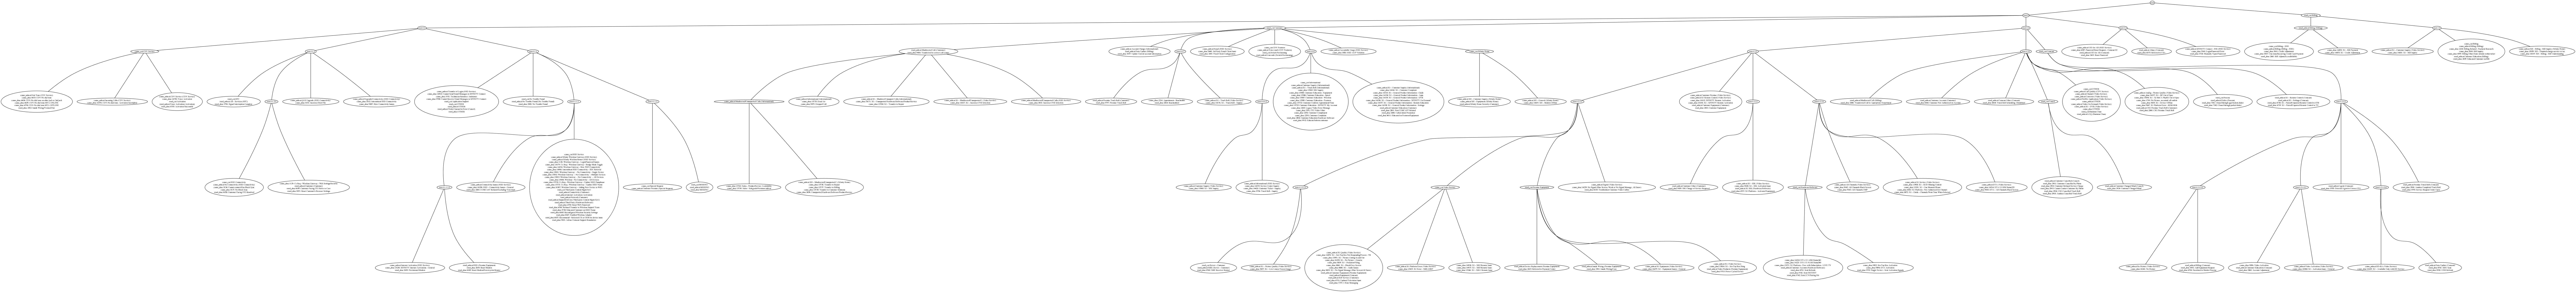

In [15]:
from IPython.display import Image
Image(filename='data/taxonomy/hierarchical_taxonomy_topdesc_internal.png')

In [14]:
# B. TF-IDF: W = [[TF(L,S)*IDF(L)]]
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X = tfidf.fit_transform(freq_mat.values)

recursive_kary_split(X,index=(subscribers,dummy_cols))

import cPickle as pickle
with open("data/taxonomy/taxonomy_graph_topdesc_tfidf_v2", 'wb') as output:
    pickle.dump(G, output, pickle.HIGHEST_PROTOCOL)

In [15]:
from pygraphviz import *
A = AGraph()
A.add_edges_from(G.edges())

for node in G.nodes():
    if 'labels' in G.node[node].keys():
        vals = [i.replace("ticket_cause_description","cause").replace("ticket_resolution_description","resol") \
                for i in G.node[node]['labels']]
        if len(vals)>0:
            A.get_node(node).attr['label'] = r"\n".join(vals)
            
A.layout(prog='dot', args='-Nfontsize=8 -Nwidth="0.2" -Nheight="0.2" -Nmargin=0 -Gfontsize=8')
A.draw('data/taxonomy/hierarchical_taxonomy_topdesc_tfidf_v2.svg')
A.draw('data/taxonomy/hierarchical_taxonomy_topdesc_tfidf_v2.png')

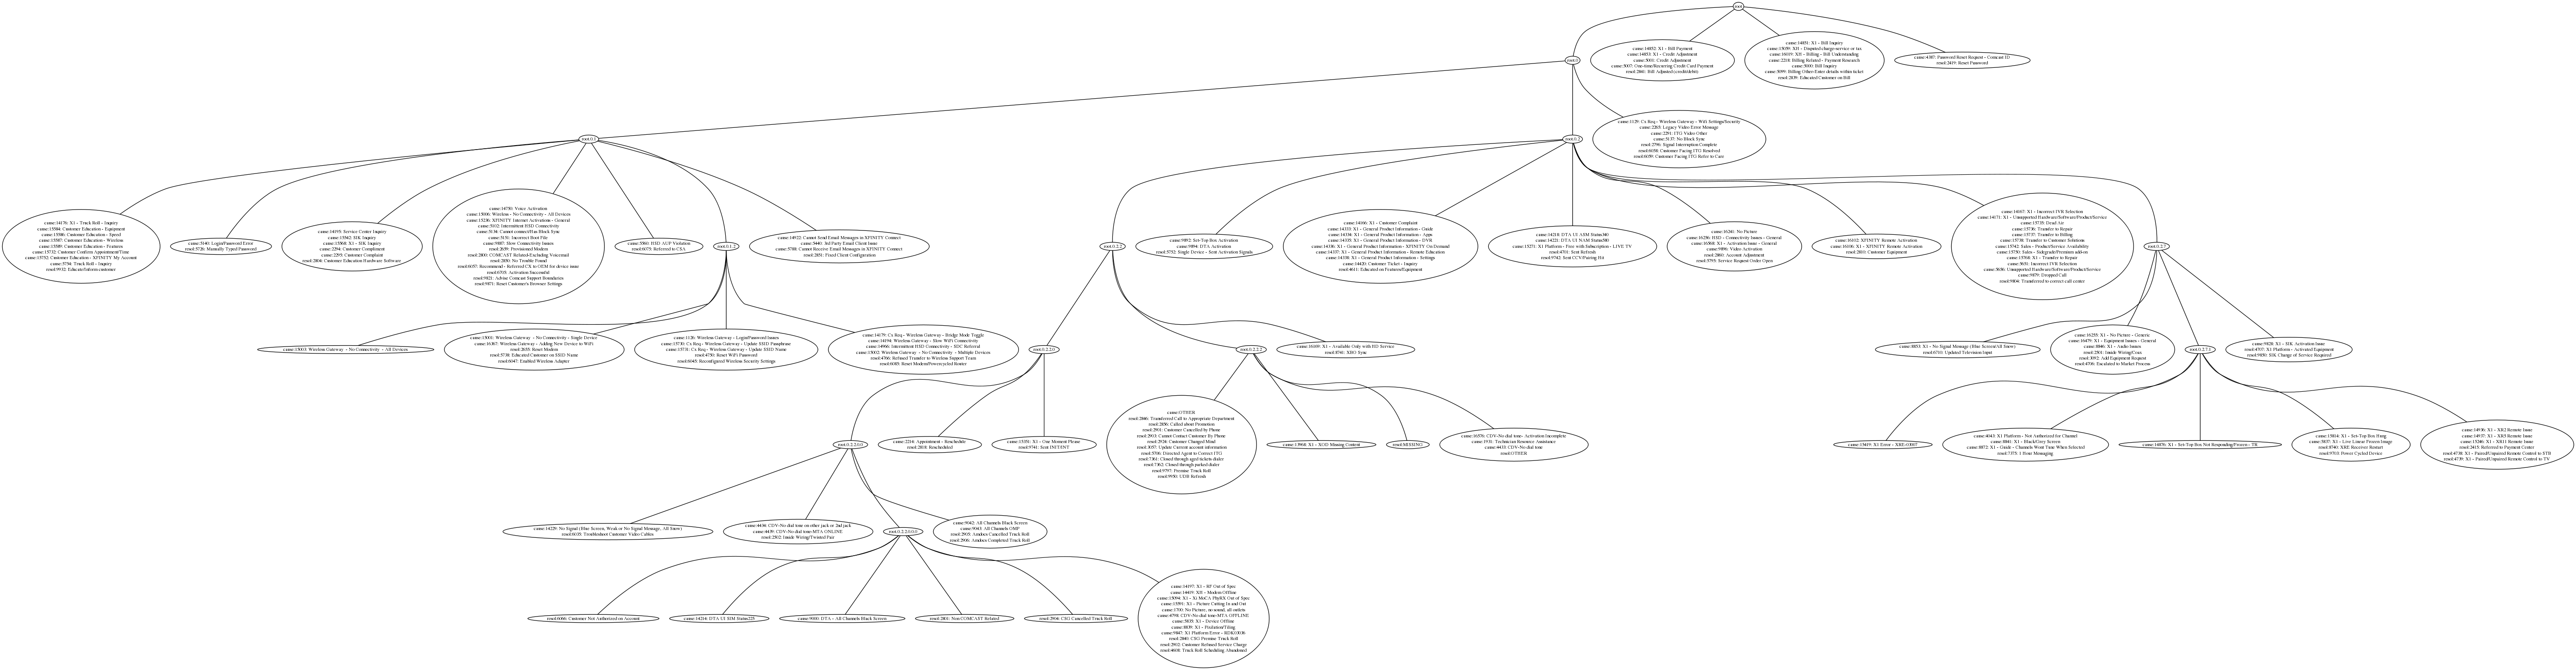

In [16]:
from IPython.display import Image
Image(filename='data/taxonomy/hierarchical_taxonomy_topdesc_tfidf_v2.png')